In [1]:
import os
import sys
import yaml

# Path to the dataset zip file
data_folder = "./data"


project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

In [2]:
from examples.minv.celebA.utils.celebA_data import get_celebA_dataloader

# Load the config.yaml file
with open('train_config.yaml', 'r') as file:
    train_config = yaml.safe_load(file)

# Generate the dataset and dataloaders
path = os.path.join(os.getcwd(), train_config["data"]["data_dir"])

#print(train_config)

train_loader, test_loader = get_celebA_dataloader(path, train_config)

num_classes = train_loader.dataset.dataset.get_classes()


Load data from ./data/celebaA_data.pkl


In [ ]:
# Plot an image from train_loader
import matplotlib.pyplot as plt
import numpy as np

# Get the first batch of images and labels
found = False
while not found:
    images, labels = next(iter(train_loader))
    labels = labels.numpy()
    for i in range(len(labels)):
        if labels[i] == 0:
            print(labels[i])
            plt.imshow(np.transpose(images[i], (1, 2, 0)))
            plt.show()
            found = True
            break


In [ ]:
from examples.mia.celebA_HQ.utils.celeb_hq_model import ResNet18
from examples.mia.celebA_HQ.utils.celeb_hq_model import create_trained_model_and_metadata
# Get number of classes from the train_loader
num_classes = train_loader.dataset.dataset.get_classes()
print(num_classes)

import torch
# Create the model
model = ResNet18(num_classes=num_classes)

device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Load the model
train_acc, train_loss, test_acc, test_loss = create_trained_model_and_metadata(model,train_loader,test_loader, train_config)



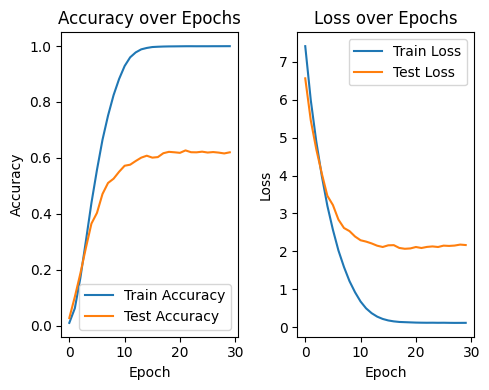

In [7]:
import matplotlib.pyplot as plt

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
# Auxiliary loader

from examples.minv.celebA.utils.celebA_data import get_celebA_auxloader

aux_loader = get_celebA_auxloader(path, train_config)



Save data to ./data/celebaA_aux_data.pkl


In [ ]:
import torch
from torch.nn import functional as F
import numpy as np
from examples.mia.celebA_HQ.utils.celeb_hq_model import ResNet18

# We have model_metadata.pkl and target_model.pkl. Load metadata and target model
# Load the model
num_classes = train_loader.dataset.dataset.get_classes()
model = ResNet18(num_classes=num_classes)
model.load_state_dict(torch.load('./target/target_model.pkl'))
model.eval()


In [9]:
# Top-n-selection

# Get the prediction confidence of each image in aux_loader using the target model
# For each image in aux_loader, we expect a vector of length #classes with the confidence of the model
# that the image belongs to each class
def get_prediction_confidence(model, aux_loader):
    model.eval()
    all_confidences = []
    for images, labels in aux_loader:
        with torch.no_grad():
            outputs = model(images)
            confidences = F.softmax(outputs, dim=1)
            all_confidences.append(confidences)
    return torch.cat(all_confidences)

confs = get_prediction_confidence(model, aux_loader)


In [ ]:
import matplotlib.pyplot as plt

pseudo_labels = torch.max(confs, dim=1)
#print(pseudo_labels)

#empty array of size num_classes
pseudo_map = [[] for _ in range(num_classes)]

for i, (conf, label) in enumerate(zip(pseudo_labels[0], pseudo_labels[1])):
    pseudo_map[label.item()].append((i, conf.item()))

# Sort pseudo_map by confidence descending
for i in range(num_classes):
    pseudo_map[i] = sorted(pseudo_map[i], key=lambda x: x[1], reverse=True)

# keep only the top n entries in each element of pseudo_map
n = 10
pseudo_map = [pseudo_map[i][:n] for i in range(num_classes)]

print(pseudo_map[0])

# Plot images with their pseudo labels for class 0
plt.figure(figsize=(20, 10))
for i, (idx, conf) in enumerate(pseudo_map[0]):
    plt.subplot(1, n, i + 1)
    plt.imshow(np.transpose(aux_loader.dataset[idx][0], (1, 2, 0)))
    plt.title(f'Conf: {conf:.2f}')
plt.tight_layout()
plt.show()

In [11]:
# save images with pseudo labels into subfolders
import os
from PIL import Image

# Create a directory to store the pseudo-labeled images
pseudo_dir = os.path.join(data_folder, 'pseudo')
os.makedirs(pseudo_dir, exist_ok=True)

# Create subdirectories for each class
for i in range(num_classes):
    os.makedirs(os.path.join(pseudo_dir, str(i)), exist_ok=True)

# Copy the images to the corresponding subdirectories
for i in range(num_classes):
    for idx, _ in pseudo_map[i]:
        img, _ = aux_loader.dataset[idx]
        # convert tensor to PIL image
        img = img.permute(1, 2, 0).numpy()
        img = Image.fromarray((img * 255).astype(np.uint8))
        img.save(os.path.join(pseudo_dir, str(i), f'{idx}.png'))
        
        

In [16]:
# Load pseudo data loader
from examples.minv.celebA.utils.celebA_data import get_celebA_pseudoloader

pseudo_loader = get_celebA_pseudoloader(path, train_config)

Load data from ./data/celebaA_pseudo_data.pkl


In [ ]:
# GAN training
from examples.minv.celebA.utils.generator import ResNetGenerator
from examples.minv.celebA.utils.discriminator import SNResNetProjectionDiscriminator
import leakpro.attacks.utils.gan_losses as losses
import kornia
import torch
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dim_z = 256

# Initialize the generator and discriminator
gen = ResNetGenerator(num_classes=num_classes, dim_z=dim_z, activation=F.relu, bottom_width=16).to(device)
dis = SNResNetProjectionDiscriminator(num_classes=num_classes, activation=F.relu).to(device)

# Load optimizers
opt_gen = torch.optim.Adam(gen.parameters(), 0.002, (0.0, 0.9))
opt_dis = torch.optim.Adam(dis.parameters(), 0.00002, (0.0, 0.9))

# Adversarial losses
gen_criterion = losses.GenLoss(loss_type='hinge', is_relativistic=False)
dis_criterion = losses.DisLoss(loss_type='hinge', is_relativistic=False)

# Augmentations for generated images
aug_list = kornia.augmentation.container.ImageSequential(
        #kornia.augmentation.RandomResizedCrop((64, 64), scale=(0.8, 1.0), ratio=(1.0, 1.0)),
        kornia.augmentation.ColorJitter(brightness=0.2, contrast=0.2, p=0.5),
        kornia.augmentation.RandomHorizontalFlip(),
        kornia.augmentation.RandomRotation(5),
    ).to(device)

In [ ]:
# Training loop
n_iter = 500
n_dis = 1
alpha = 0.2
log_interval = 10

model.to(device)
model.eval()


torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.backends.cudnn.benchmark = True

def sample_from_generator(gen, n_classes, batch_size, device):
    """Sample random z and y from the generator"""
    
    z = torch.empty(batch_size, dim_z, dtype=torch.float32, device=device).normal_()
    y = torch.randint(0, n_classes, (batch_size,)).to(device)
    return gen(z, y), y, z


gen_losses = []
dis_losses = []
inv_losses = []

# Training loop
for i in range(n_iter):
    _l_g = .0
    cumulative_inv_loss = 0.
    cumulative_loss_dis = .0

    cumulative_target_acc = .0
    target_correct = 0
    count = 0
    for j in range(n_dis):
        if j == 0:
            fake, fake_labels, _ = sample_from_generator(gen, num_classes, 128, device)
            fake_aug = aug_list(fake)
            dis_fake = dis(fake_aug, fake_labels)

            inv_loss = losses.max_margin_loss(model(fake_aug), fake_labels)

            inv_losses.append(inv_loss.item())
            dis_real = None

            loss_gen = gen_criterion(dis_fake, dis_real)
            gen_losses.append(loss_gen.item())
            loss_all = loss_gen + inv_loss*alpha

            gen.zero_grad()
            loss_all.backward()
            opt_gen.step()
            _l_g += loss_gen.item()
            cumulative_inv_loss += inv_loss.item()

        fake, fake_labels, _ = sample_from_generator(gen, num_classes, 128, device)

        real, real_labels = next(iter(pseudo_loader))
        real, real_labels = real.to(device), real_labels.to(device)

        dis_fake = dis(fake, fake_labels)
        dis_real = dis(real, real_labels)

        loss_dis = dis_criterion(dis_fake, dis_real)
        
        dis.zero_grad()
    
        loss_dis.backward()
        opt_dis.step()

        cumulative_loss_dis += loss_dis.item()
        dis_losses.append(cumulative_loss_dis/n_dis)
        
        with torch.no_grad():
            count += fake.shape[0]
            T_logits = model(fake)
            T_preds = T_logits.max(1, keepdim=True)[1]
            target_correct += T_preds.eq(fake_labels.view_as(T_preds)).sum().item()
            cumulative_target_acc += round(target_correct / count, 4)

    if i % log_interval == 0:
        print(
                'iteration: {:05d}/{:05d}, loss gen: {:05f}, loss dis {:05f}, inv loss {:05f}, target acc {:04f}'.format(
                    i, n_iter, _l_g, cumulative_loss_dis, cumulative_inv_loss,
                    cumulative_target_acc, ))
        
        if cumulative_target_acc > 0.2:
            break

# Save the generator and discriminator
torch.save(gen.state_dict(), 'generator.pth')
torch.save(dis.state_dict(), 'discriminator.pth')


In [ ]:
import matplotlib.pyplot as plt
# Plot all 3 losses
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(gen_losses)
plt.xlabel('Iteration')
plt.ylabel('Generator Loss')
plt.title('Generator Loss')

plt.subplot(1, 3, 2)
plt.plot(dis_losses)
plt.xlabel('Iteration')
plt.ylabel('Discriminator Loss')
plt.title('Discriminator Loss')

plt.subplot(1, 3, 3)
plt.plot(inv_losses)
plt.xlabel('Iteration')
plt.ylabel('Invariance Loss')
plt.title('Invariance Loss')

plt.tight_layout()
plt.show()


### Model Inversion Attack on Identifier Model 

tensor([1373, 2336, 1357,  209], device='cuda:0')


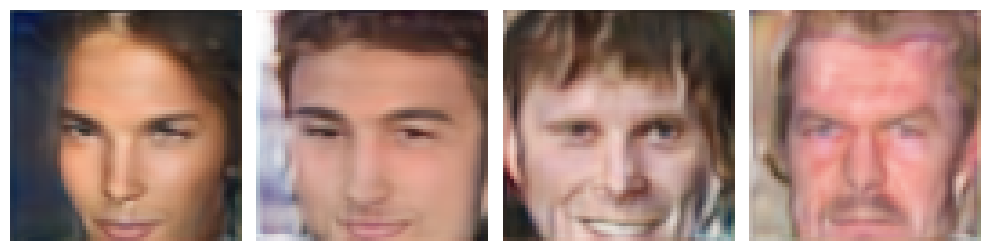

In [ ]:
from examples.minv.celebA.utils.generator import ResNetGenerator
import torch
import matplotlib.pyplot as plt
import numpy as np

"""Generate example images using the trained generator"""

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dim_z = 256
# Load generator and discriminator
gen = ResNetGenerator(num_classes=num_classes, dim_z=dim_z).to(device)
gen.load_state_dict(torch.load('gen.pth'))

# Generate images
gen.eval()

n_images = 4
z = torch.empty(n_images, dim_z, dtype=torch.float32, device=device).normal_()
y = torch.randint(0, num_classes, (n_images,)).to(device) # random labels
#y = torch.tensor([0, 1, 2, 3]).to(device) # fixed labels
print(y) 

with torch.no_grad():
    fake = gen(z, y)

# Normalize the generated images to the range [0, 1]
fake = (fake - fake.min()) / (fake.max() - fake.min())

# Plot the generated images
plt.figure(figsize=(10, 5))
for i in range(n_images):
    plt.subplot(1, n_images, i + 1)
    plt.imshow(np.transpose(fake[i].cpu().numpy(), (1, 2, 0)))
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from leakpro import LeakPro
from examples.minv.celebA.celebA_plgmi_handler import CelebA_InputHandler
config_path = "audit.yaml"


# Initialize the LeakPro object
leakpro = LeakPro(CelebA_InputHandler, config_path)

# Run the audit
results = leakpro.run_audit(return_results=True)  


2025-02-21 08:18:48,123 INFO     Target model blueprint created from ResNet18 in ../../mia/celebA_HQ/utils/celeb_hq_model.py.
INFO:leakpro:Target model blueprint created from ResNet18 in ../../mia/celebA_HQ/utils/celeb_hq_model.py.
2025-02-21 08:18:48,126 INFO     Loaded target model metadata from ./target/model_metadata.pkl
INFO:leakpro:Loaded target model metadata from ./target/model_metadata.pkl


Configurations: {'audit': {'random_seed': 1234, 'attack_list': {'plgmi': {'n_dis': 2, 'n_iter': 10000, 'batch_size': 32, 'gen_lr': 0.0005, 'dis_lr': 0.0002, 'gen_beta1': 0.0, 'gen_beta2': 0.9, 'dis_beta1': 0.0, 'dis_beta2': 0.9, 'dim_z': 256, 'alpha': 0.2, 'log_interval': 10, 'num_classes': 2500, 'generator': {'module_path': './utils/generator.py', 'model_class': 'ResNetGenerator', 'checkpoint_path': 'gen.pth', 'init_params': {'dim_z': 256, 'num_classes': 2500, 'bottom_width': 4}}, 'discriminator': {'module_path': './utils/discriminator.py', 'model_class': 'SNResNetProjectionDiscriminator', 'checkpoint_path': 'dis.pth', 'init_params': {'num_classes': 2500}}}}, 'reconstruction': {'num_class_samples': 1, 'num_audited_classes': 2500, 'metrics': {'accuracy': None}}, 'output_dir': './leakpro_output', 'attack_type': 'minv', 'modality': 'image'}, 'target': {'module_path': '../../mia/celebA_HQ/utils/celeb_hq_model.py', 'model_class': 'ResNet18', 'target_folder': './target', 'data_path': './dat

2025-02-21 08:18:48,408 INFO     Loaded target model from ./target
INFO:leakpro:Loaded target model from ./target
2025-02-21 08:18:51,806 INFO     Loaded population dataset from ./data/celebaA_data.pkl
INFO:leakpro:Loaded population dataset from ./data/celebaA_data.pkl
2025-02-21 08:18:51,808 INFO     Loaded population dataset from ./data/celebaA_data.pkl
INFO:leakpro:Loaded population dataset from ./data/celebaA_data.pkl
2025-02-21 08:18:52,138 INFO     MINV attack factory loaded.
INFO:leakpro:MINV attack factory loaded.
2025-02-21 08:18:52,140 INFO     Configuring PLG-MI attack
INFO:leakpro:Configuring PLG-MI attack
2025-02-21 08:18:52,165 INFO     Added attack: plgmi
INFO:leakpro:Added attack: plgmi
2025-02-21 08:18:52,166 INFO     Preparing attack: plgmi
INFO:leakpro:Preparing attack: plgmi
2025-02-21 08:18:52,167 INFO     Preparing attack
INFO:leakpro:Preparing attack
2025-02-21 08:18:52,169 INFO     Setting up generator configurations
INFO:leakpro:Setting up generator configurati

AttributeError: 'dict' object has no attribute 'attack_name'